In [ ]:
!pip install transformers datasets --quiet


In [ ]:
import pandas as pd

# Load the dataset
df = pd.read_csv("PhiUSIIL_Phishing_URL_Dataset.csv")

# Show basic info
print("Shape:", df.shape)
df.head()


Shape: (235795, 56)


,FILENAME,URL,URLLength,Domain,DomainLength,IsDomainIP,TLD,URLSimilarityIndex,CharContinuationRate,TLDLegitimateProb,...,Pay,Crypto,HasCopyrightInfo,NoOfImage,NoOfCSS,NoOfJS,NoOfSelfRef,NoOfEmptyRef,NoOfExternalRef,label
0,521848.txt,https://www.southbankmosaics.com,31,www.southbankmosaics.com,24,0,com,100.0,1.000000,0.522907,...,0,0,1,34,20,28,119,0,124,1
1,31372.txt,https://www.uni-mainz.de,23,www.uni-mainz.de,16,0,de,100.0,0.666667,0.032650,...,0,0,1,50,9,8,39,0,217,1
2,597387.txt,https://www.voicefmradio.co.uk,29,www.voicefmradio.co.uk,22,0,uk,100.0,0.866667,0.028555,...,0,0,1,10,2,7,42,2,5,1
3,554095.txt,https://www.sfnmjournal.com,26,www.sfnmjournal.com,19,0,com,100.0,1.000000,0.522907,...,1,1,1,3,27,15,22,1,31,1
4,151578.txt,https://www.rewildingargentina.org,33,www.rewildingargentina.org,26,0,org,100.0,1.000000,0.079963,...,1,0,1,244,15,34,72,1,85,1


In [ ]:
# Check column names
df.columns


Index(['FILENAME', 'URL', 'URLLength', 'Domain', 'DomainLength', 'IsDomainIP',
       'TLD', 'URLSimilarityIndex', 'CharContinuationRate',
       'TLDLegitimateProb', 'URLCharProb', 'TLDLength', 'NoOfSubDomain',
       'HasObfuscation', 'NoOfObfuscatedChar', 'ObfuscationRatio',
       'NoOfLettersInURL', 'LetterRatioInURL', 'NoOfDegitsInURL',
       'DegitRatioInURL', 'NoOfEqualsInURL', 'NoOfQMarkInURL',
       'NoOfAmpersandInURL', 'NoOfOtherSpecialCharsInURL',
       'SpacialCharRatioInURL', 'IsHTTPS', 'LineOfCode', 'LargestLineLength',
       'HasTitle', 'Title', 'DomainTitleMatchScore', 'URLTitleMatchScore',
       'HasFavicon', 'Robots', 'IsResponsive', 'NoOfURLRedirect',
       'NoOfSelfRedirect', 'HasDescription', 'NoOfPopup', 'NoOfiFrame',
       'HasExternalFormSubmit', 'HasSocialNet', 'HasSubmitButton',
       'HasHiddenFields', 'HasPasswordField', 'Bank', 'Pay', 'Crypto',
       'HasCopyrightInfo', 'NoOfImage', 'NoOfCSS', 'NoOfJS', 'NoOfSelfRef',
       'NoOfEmptyRef', 'NoOf

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# 1. Keep only required columns
df = df[['URL', 'label']].dropna()

# 2. Convert labels (if not already 0 and 1)
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['label'])

# 3. Train-test split (80% train, 20% validation)
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['URL'].tolist(),
    df['label'].tolist(),
    test_size=0.2,
    random_state=42,
    stratify=df['label']
)

print(f"Train size: {len(train_texts)}, Validation size: {len(val_texts)}")


Train size: 188636, Validation size: 47159


In [ ]:
from transformers import BertTokenizer

# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the URLs
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=64)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=64)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
import torch

# Custom dataset class for BERT
class URLDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.encodings['input_ids'][idx]),
            'attention_mask': torch.tensor(self.encodings['attention_mask'][idx]),
            'labels': torch.tensor(self.labels[idx])
        }

    def __len__(self):
        return len(self.labels)

# Convert to datasets
train_dataset = URLDataset(train_encodings, train_labels)
val_dataset = URLDataset(val_encodings, val_labels)


In [ ]:
from transformers import BertForSequenceClassification, AdamW

# Load BERT model with 2 output classes (phishing / benign)
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model.to("cuda")  # Move to GPU if available


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
from torch.utils.data import DataLoader
from transformers import AdamW

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

# Optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)


/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
from transformers import get_scheduler
from tqdm import tqdm
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.train()

num_epochs = 2
num_training_steps = num_epochs * len(train_loader)
lr_scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

for epoch in range(num_epochs):
    total_loss = 0
    correct = 0
    total = 0

    loop = tqdm(train_loader, leave=True)
    for batch in loop:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        lr_scheduler.step()

        preds = torch.argmax(logits, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        total_loss += loss.item()

        loop.set_description(f"Epoch {epoch+1}")
        loop.set_postfix(loss=loss.item(), acc=100 * correct / total)


Epoch 2: 100%|██████████| 5895/5895 [34:31<00:00,  2.85it/s, acc=99.8, loss=0.00167]


              precision    recall  f1-score   support

      Benign       1.00      1.00      1.00     20189
    Phishing       1.00      1.00      1.00     26970

    accuracy                           1.00     47159
   macro avg       1.00      1.00      1.00     47159
weighted avg       1.00      1.00      1.00     47159



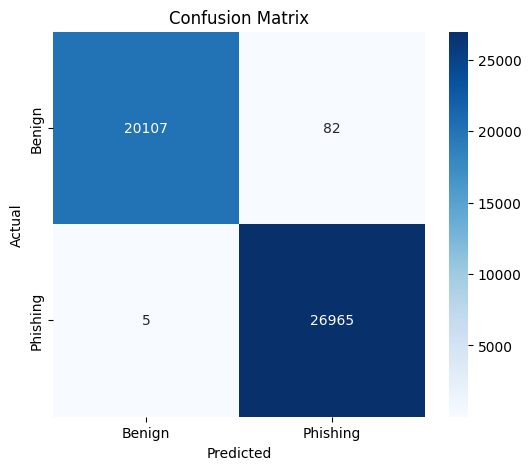

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Classification report
print(classification_report(all_labels, all_preds, target_names=["Benign", "Phishing"]))

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Benign", "Phishing"], yticklabels=["Benign", "Phishing"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
# Test URLs
test_urls = [
    "http://testsafebrowsing.appspot.com/s/malware.html",
    "http://malware.testing.google.test/testing/malware/",
    "http://testsafebrowsing.appspot.com/s/phishing.html",
    "http://testsafebrowsing.appspot.com/s/social_engineering.html",
    "http://testsafebrowsing.appspot.com/s/unwanted.html",
    "http://testsafebrowsing.appspot.com/apiv4/ANY_PLATFORM/MALWARE/URL/",
    "http://testsafebrowsing.appspot.com/apiv4/ANY_PLATFORM/SOCIAL_ENGINEERING/URL/",
    "http://malware.wicar.org/data/ms13_069_c.html",
    "http://malware.wicar.org/data/launch_windows_media_player.html",
    "http://malware.wicar.org/data/java_pdf_popup.html"
]

# Tokenize test URLs
test_inputs = tokenizer(test_urls, truncation=True, padding=True, return_tensors="pt", max_length=64)
test_inputs = {k: v.to(device) for k, v in test_inputs.items()}

# Predict
model.eval()
with torch.no_grad():
    outputs = model(**test_inputs)
    predictions = torch.argmax(outputs.logits, dim=1)

# Display results
for url, pred in zip(test_urls, predictions):
    label = "Phishing" if pred.item() == 1 else "Benign"
    print(f"{url} → {label}")


http://testsafebrowsing.appspot.com/s/malware.html → Benign
http://malware.testing.google.test/testing/malware/ → Benign
http://testsafebrowsing.appspot.com/s/phishing.html → Benign
http://testsafebrowsing.appspot.com/s/social_engineering.html → Benign
http://testsafebrowsing.appspot.com/s/unwanted.html → Benign
http://testsafebrowsing.appspot.com/apiv4/ANY_PLATFORM/MALWARE/URL/ → Benign
http://testsafebrowsing.appspot.com/apiv4/ANY_PLATFORM/SOCIAL_ENGINEERING/URL/ → Benign
http://malware.wicar.org/data/ms13_069_c.html → Benign
http://malware.wicar.org/data/launch_windows_media_player.html → Benign
http://malware.wicar.org/data/java_pdf_popup.html → Benign


In [ ]:
model.save_pretrained("./bert_phishing_model")
tokenizer.save_pretrained("./bert_phishing_model")


('./bert_phishing_model/tokenizer_config.json',
 './bert_phishing_model/special_tokens_map.json',
 './bert_phishing_model/vocab.txt',
 './bert_phishing_model/added_tokens.json')

In [ ]:
!zip -r bert_phishing_model.zip bert_phishing_model/


  adding: bert_phishing_model/ (stored 0%)
  adding: bert_phishing_model/special_tokens_map.json (deflated 42%)
  adding: bert_phishing_model/vocab.txt (deflated 53%)
  adding: bert_phishing_model/config.json (deflated 49%)
  adding: bert_phishing_model/tokenizer_config.json (deflated 45%)
  adding: bert_phishing_model/pytorch_model.bin (deflated 7%)
